<a href="https://colab.research.google.com/github/michaelachmann/social-media-lab/blob/main/notebooks/2025_01_08_Text_Classification_BERT_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning Notebook [![DOI](https://zenodo.org/badge/660157642.svg)](https://zenodo.org/badge/latestdoi/660157642)
![Notes on (Computational) Social Media Research Banner](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/banner.png)

## Overview

This Jupyter notebook is a part of the social-media-lab.net project, which is a work-in-progress textbook on computational social media analysis. The notebook is intended for use in my classes.

The **BERT Fine-Tuning Notebook** provides a comprehensive guide to fine-tuning pre-trained BERT models for text classification tasks, with a focus on binary classification. Designed for use in computational social media analysis, the notebook covers essential steps including dataset preparation, handling class imbalance, and implementing a custom training loop with class weights. It also integrates hyperparameter tuning using Weights & Biases (wandb) for systematic experimentation and evaluation.

### Project Information

- Project Website: [social-media-lab.net](https://social-media-lab.net/)
- GitHub Repository: [https://github.com/michaelachmann/social-media-lab](https://github.com/michaelachmann/social-media-lab)

## License Information

This notebook, along with all other notebooks in the project, is licensed under the following terms:

- License: [GNU General Public License version 3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.de.html)
- License File: [LICENSE.md](https://github.com/michaelachmann/social-media-lab/blob/main/LICENSE.md)

## Citation

If you use or reference this notebook in your work, please cite it appropriately. Here is an example of the citation:

```
Michael Achmann. (2024). michaelachmann/social-media-lab: 2024-12-9 (v0.0.15). Zenodo. https://doi.org/10.5281/zenodo.8199902
```

First of all we import our annotated dataset and rename the `Majority Decision` column to `labels`:

In [ ]:
import pandas as pd

original_df = pd.read_csv('/content/drive/MyDrive/2024-05-22-Call-To-Action-Ground-Truth.csv')
original_df['text'] = original_df['Text']
original_df['labels'] = original_df['Majority Decision']

**Splitting the Dataset: Training, Validation, and Test Sets**

Next, we want to split our human annotated dataset into three smaller datasets: We want to maintain an independet `test_df` dataset, that is not at all used during model training, and we need a `train_df` and an `eval_df` for model training. In the code, we use the `train_test_split` function from `scikit-learn` to perform two splits:


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(original_df[['text', 'labels']], test_size=0.2, stratify=original_df['labels'], random_state=5460)

- **Purpose**: The first split separates the dataset into the training/validation set (`train_df`) and the test set (`test_df`).
- **Size**:
  - `test_size=0.2` specifies that 20% of the original dataset is reserved for testing.
  - This ensures the **test set (`test_df`)** remains isolated from the training process and provides a reliable measure of the model’s generalization performance.
  - The remaining 80% of the data is retained as the initial **training/validation set (`train_df`)**.
- **Stratification**: We set `stratify=original_df['labels']` to maintain the label distribution across both subsets, ensuring that classes are evenly represented in the training and test sets.
- **Random State**: By setting `random_state=5460`, we ensure reproducibility, meaning the same split will be generated each time the code is run.

In [ ]:
train_df, val_df = train_test_split(original_df[['text', 'labels']], test_size=0.25, stratify=original_df['labels'], random_state=5460)

- **Purpose**: The second split divides the initial training/validation set (`train_df`) into the actual **training set (`train_df`)** and the **validation set (`val_df`)**.
- **Size**:
  - `test_size=0.25` means that 25% of the data remaining after the first split (80% of the original dataset) is allocated for validation.
  - This results in the **validation set (`val_df`)** being 20% of the original dataset (0.25 × 80%).
  - The remaining 60% of the original dataset becomes the final **training set (`train_df`)**.
- **Stratification**: Again, stratification ensures the label distribution remains consistent between the training and validation sets.
- **Random State**: The same `random_state=5460` ensures consistency in the splits.

### Why These Split Sizes?
1. **Training Set (`train_df`) - 60% of the Original Dataset**:
   - This subset is the largest to provide the model with enough examples to learn meaningful patterns. In supervised learning, having more data generally improves the model’s ability to generalize.

2. **Validation Set (`val_df`) - 20% of the Original Dataset**:
   - The validation set is large enough to provide reliable feedback on model performance during training. It’s used to tune hyperparameters, monitor for overfitting, and select the best model without being so large that it detracts significantly from the training data.

3. **Test Set (`test_df`) - 20% of the Original Dataset**:
   - By holding back 20% of the dataset as an unseen test set, we can accurately evaluate the model’s performance after training is complete. A larger test set might reduce the data available for training, while a smaller one might not provide reliable evaluation metrics.

Next, we save the splits:

In [ ]:
test_df.to_csv('/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TEST.csv')
train_df.to_csv('/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TRAIN.csv')
val_df.to_csv('/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-VAL.csv')

Saving the splits ensures **consistency** across experiments. By working with the same training, validation, and test sets, we can:
- Compare results fairly, even when modifying models or hyperparameters.
- Avoid re-computation, keeping the test set isolated and unaltered for unbiased final evaluations.
- Facilitate reproducibility for future use or collaboration.

### Fine-Tuning a First Model

Now we are ready to fine-tune a first model following the next steps:

#### 1. Set up the environment and load data
  
We first determine if a GPU is available (for faster training) and specify which pretrained model we want to use. Then, we load the training and validation datasets from CSV files.

In [ ]:
!pip -q install transformers[torch] datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, predictions, average='binary'),
        "recall": recall_score(labels, predictions, average='binary'),
        "f1_score": f1_score(labels, predictions, average='binary')
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = "deepset/gbert-base"  # Example German BERT model

# Load the training and validation data
train_df = pd.read_csv("/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TRAIN.csv")
val_df = pd.read_csv("/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-VAL.csv")

In [ ]:
train_df.head()

Unnamed: 0                                               text  labels
0         209  „Klatschen reicht nicht!“, betont @olafscholz ...   False
1          92             Für einen Kurs der Mitte. #wegenmorgen   False
2         249  Ich bin Ricarda, stellvertretende Bundesvorsit...   False
3        1202                                                CSU   False
4         225  Dieses Versprechen, dass wir die sind, die Str...   False

#### 2. Encode labels and handle imbalanced classes

Next, we encode text-based labels (e.g., "True"/"False") into numeric format. We also compute **class weights** to address any class imbalance that could negatively impact training.

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["labels"])
val_labels = label_encoder.transform(val_df["labels"])

# Compute class weights (helpful for imbalanced classes)
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#### 3. Define a custom Trainer class for class weights

By default, the Hugging Face `Trainer` does not support class weighting directly. We subclass `Trainer` and override `compute_loss` to insert a weighted cross-entropy loss function.

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### 4. Tokenize the data and create Dataset objects

We use the pretrained tokenizer to convert raw text into integer IDs, define attention masks, and then convert these tokenized results into a Hugging Face `Dataset` object. This makes the data easy to feed into the trainer.

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Tokenize the data
train_encodings = tokenizer(
    train_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    val_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

# Create Dataset objects
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

#### 5. Set up training arguments

**Explanation**:  
Here, we define how many epochs to train for, the batch size, and when to evaluate the model. We keep these settings simple so students can focus on the basics.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",                # Directory to save model checkpoints and results
    num_train_epochs=6,                    # Number of training epochs
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    learning_rate=0.00004,                 # Learning rate
    weight_decay=0.05,                     # Regularization to prevent overfitting
    eval_strategy="epoch",           # Evaluate the model after every epoch
    save_strategy="epoch",                 # Save model checkpoints after every epoch
    metric_for_best_model="f1_score",      # Maximize the F1 score during training
    greater_is_better=True,                # Indicate that higher F1 scores are better
    load_best_model_at_end=True,           # Load the best model (based on F1) after training
    logging_strategy="steps",              # Enable logging at regular intervals
    logging_steps=10                       # Log every 10 steps (adjust as needed)
)

#### 6. Initialize the model and run the training

Lastly, we load the pretrained model for sequence classification, wrap it in our custom trainer class (so we can use weighted loss), and run both training and evaluation.

In [ ]:
# Initialize model and Trainer
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=2,  # Binary classification
    problem_type="single_label_classification"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train and evaluate the model
trainer.train()
results = trainer.evaluate()
print("Final results:", results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Final results: {'eval_loss': 0.4846676290035248, 'eval_precision': 0.8142857142857143, 'eval_recall': 0.8507462686567164, 'eval_f1_score': 0.8321167883211679, 'eval_runtime': 5.1593, 'eval_samples_per_second': 67.258, 'eval_steps_per_second': 4.264, 'epoch': 6.0}


#### Interpretation of Training Results

The training results show improvement in **F1 score**, reaching **0.832** by epoch 6, indicating a good balance between **precision** (0.814) and **recall** (0.850). While the **validation loss** fluctuates (e.g., peaking at epoch 3), the overall trend suggests the model is learning effectively.

The improvements in recall imply that the model captures most relevant samples, while precision, though slightly lower, ensures fewer false positives.

These results provide a baseline for exploring **hyperparameter tuning**. For example:
- Could a slightly higher or lower **learning rate** yield faster convergence or better results?
- Would increasing or decreasing the **batch size** impact model stability or generalization?
- How many **epochs** are truly optimal for this task?

In the next section, we will use Weights & Balances for tuning key hyperparameters to push model performance beyond this baseline.

## Hyperparameter Tuning

In [ ]:
!pip install -q wandb

In [ ]:
import wandb
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback

#########################
# 1) Define Your Metrics
#########################
def compute_metrics(eval_pred):
    """
    Computes precision, recall, and F1 score for a binary classification problem.
    Returns a dictionary that Hugging Face's Trainer can use. **IMPORTANT** We
    use Binary F1 in this example!
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, predictions, average='binary'),
        "recall": recall_score(labels, predictions, average='binary'),
        "f1_score": f1_score(labels, predictions, average='binary')
    }

###############################
# 2) Prepare Your Dataset
###############################
def prepare_data(
    train_csv_path,
    val_csv_path,
    tokenizer_model="deepset/gbert-base"
):
    """
    Loads, concatenates, and encodes training and validation data.
    Also computes class weights for imbalanced datasets.
    Returns train_dataset, val_dataset, label_encoder, and class_weights.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_df = pd.read_csv(train_csv_path)[['text', 'labels']]
    val_df = pd.read_csv(val_csv_path)[['text', 'labels']]

    # Encode labels
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_df['labels'])
    val_labels = label_encoder.transform(val_df['labels'])

    # Compute class weights (helpful for imbalanced data)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

    # Tokenize text
    train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=512)
    val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=512)

    # Create Hugging Face Datasets
    train_dataset = Dataset.from_dict({
        "input_ids": train_encodings['input_ids'],
        "attention_mask": train_encodings['attention_mask'],
        "labels": train_labels
    })
    val_dataset = Dataset.from_dict({
        "input_ids": val_encodings['input_ids'],
        "attention_mask": val_encodings['attention_mask'],
        "labels": val_labels
    })

    return train_dataset, val_dataset, label_encoder, class_weights

#################################
# 3) Custom Trainer for Class Weights
#################################
class CustomTrainer(Trainer):
    """
    Subclass of Hugging Face Trainer that applies class weights
    to the loss function (useful for imbalanced classification).
    """
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use CrossEntropyLoss with custom class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

##############################
# 4) Define Training Function
##############################
def train_and_evaluate(config=None):
    """
    Main training function that:
    1) Initializes a wandb run.
    2) Prepares data and model.
    3) Trains the model with specified hyperparameters (from `config`).
    4) Evaluates and logs final results.
    """
    with wandb.init(config=config):
        # Access hyperparameters from wandb.config
        config = wandb.config

        # --------------------
        # A) Prepare Data
        # --------------------
        train_dataset, val_dataset, label_encoder, class_weights = prepare_data(
            train_csv_path="/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TRAIN.csv",
            val_csv_path="/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-VAL.csv",
            tokenizer_model="deepset/gbert-base"
        )

        # --------------------
        # B) Model & Trainer
        # --------------------
        model = AutoModelForSequenceClassification.from_pretrained(
            "deepset/gbert-base",
            num_labels=2,  # binary classification
            problem_type="single_label_classification"
        )

        training_args = TrainingArguments(
            output_dir='./results',                     # Directory to save training outputs like checkpoints and logs
            num_train_epochs=config.num_train_epochs,  # Number of epochs to train the model, set from the configuration
            per_device_train_batch_size=config.batch_size,  # Batch size for training on each device (e.g., GPU or CPU)
            per_device_eval_batch_size=config.batch_size,   # Batch size for evaluation on each device
            warmup_steps=config.warmup_steps,          # Number of steps for learning rate warm-up to stabilize initial training
            weight_decay=config.weight_decay,          # Weight decay (L2 regularization) for optimizer to prevent overfitting
            learning_rate=config.learning_rate,        # Initial learning rate for the optimizer, set from the configuration
            eval_strategy="epoch",                     # Evaluate the model at the end of each epoch
            save_strategy="epoch",                     # Save model checkpoints at the end of each epoch
            metric_for_best_model="f1_score",          # Specify the metric to use for selecting the best model (F1 score here)
            greater_is_better=True,                    # Indicate that higher values of the F1 score are better
            load_best_model_at_end=True,               # Automatically load the model with the best F1 score after training
            logging_strategy="steps",                  # Log training progress at regular step intervals
            logging_steps=10,                          # Log metrics and progress every 10 training steps
            report_to='wandb'                          # Report logs and metrics to Weights & Biases (wandb) for tracking
        )


        trainer = CustomTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            class_weights=class_weights,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        # --------------------
        # C) Train & Evaluate
        # --------------------
        trainer.train()
        final_results = trainer.evaluate()

        # --------------------
        # D) Log Results
        # --------------------
        wandb.log({"final_results": final_results})
        print("Final results:", final_results)

        wandb.finish()

In [ ]:
#####################################
# 5) Example: Running a Hyperparam Sweep
#####################################
"""
Example of defining a hyperparameter sweep in wandb.
This sweep will try different learning rates, weight decays, etc.
You can adjust the ranges to your liking.
"""
sweep_config = {
    "method": "bayes",  # Use Bayesian optimization to find the best combination of parameters
    "metric": {
        "name": "eval_f1_score",  # Evaluation metric to be optimized (F1 score in this case)
        "goal": "maximize"        # Aim to maximize the F1 score during the sweep
    },
    "parameters": {
        "num_train_epochs": {
            "values": [4, 6, 8]  # Test a range of epochs, including the current best (6), and fewer/more epochs
        },
        "learning_rate": {
            "values": [2e-5, 3e-5, 4e-5]  # Search around the current best learning rate (4e-5)
        },
        "weight_decay": {
            "values": [0.01, 0.03, 0.05]  # Test a slightly wider range of weight decay values for regularization
        },
        "warmup_steps": {
            "values": [0, 100, 500]  # Experiment with different warmup steps to stabilize training
        },
        "batch_size": {
            "values": [8, 16, 32]  # Test a range of batch sizes to balance stability and generalization
        }
    }
}

# Create sweep
sweep_id = wandb.sweep(sweep_config, project="CSS-Sem")
# Start the sweep
wandb.agent(sweep_id, function=train_and_evaluate)

#### Interpreting the Sweep Output

Hyperparameter sweeps help us identify the best parameter combinations for our model. Below, we interpret an example sweep output to understand how metrics evolve and determine the optimal settings.

**Key Points:**<br/>

1.	Sweep Configuration:
  
  Each run explores a specific combination of hyperparameters. For instance:
	* batch_size: 16
	* learning_rate: 2e-5
	* num_train_epochs: 4
	* weight_decay: 0.01
	* warmup_steps: 0
  
  These values are locked for each run as part of the sweep.

2.	Training Progress:
	* Metrics like F1 score, precision, and recall should improve across epochs.
	* Validation Loss should decrease or stabilize, confirming that the model is learning effectively.

3.	Final Results:
	* The highest F1 score across all epochs.
	* Metrics such as runtime and samples per second are useful for comparing computational efficiency.

4.	Visual Insights:
	* Run history plots (e.g., F1 score and loss) provide trends over epochs.
	*	Use these visualizations to spot patterns or anomalies in training progress.

#### Finding the Best Parameters

The best parameters are determined by our selected optimization metric. In our case we selected the (binary) F1 score. Using the Bayesian optimization method, the sweep selects the next set of parameters based on past runs, progressively narrowing in on the best configuration. Using this method, the sweep does not automatically stop:
> An important note here is for both random search and Bayesian search, you need to manually terminate the search process once you get to the desired result. You can easily do that by going to your respective Sweeps page while that is running and navigating to Sweep Controls.

-- [The W&B documentation offers an extensive tutorial](https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw)

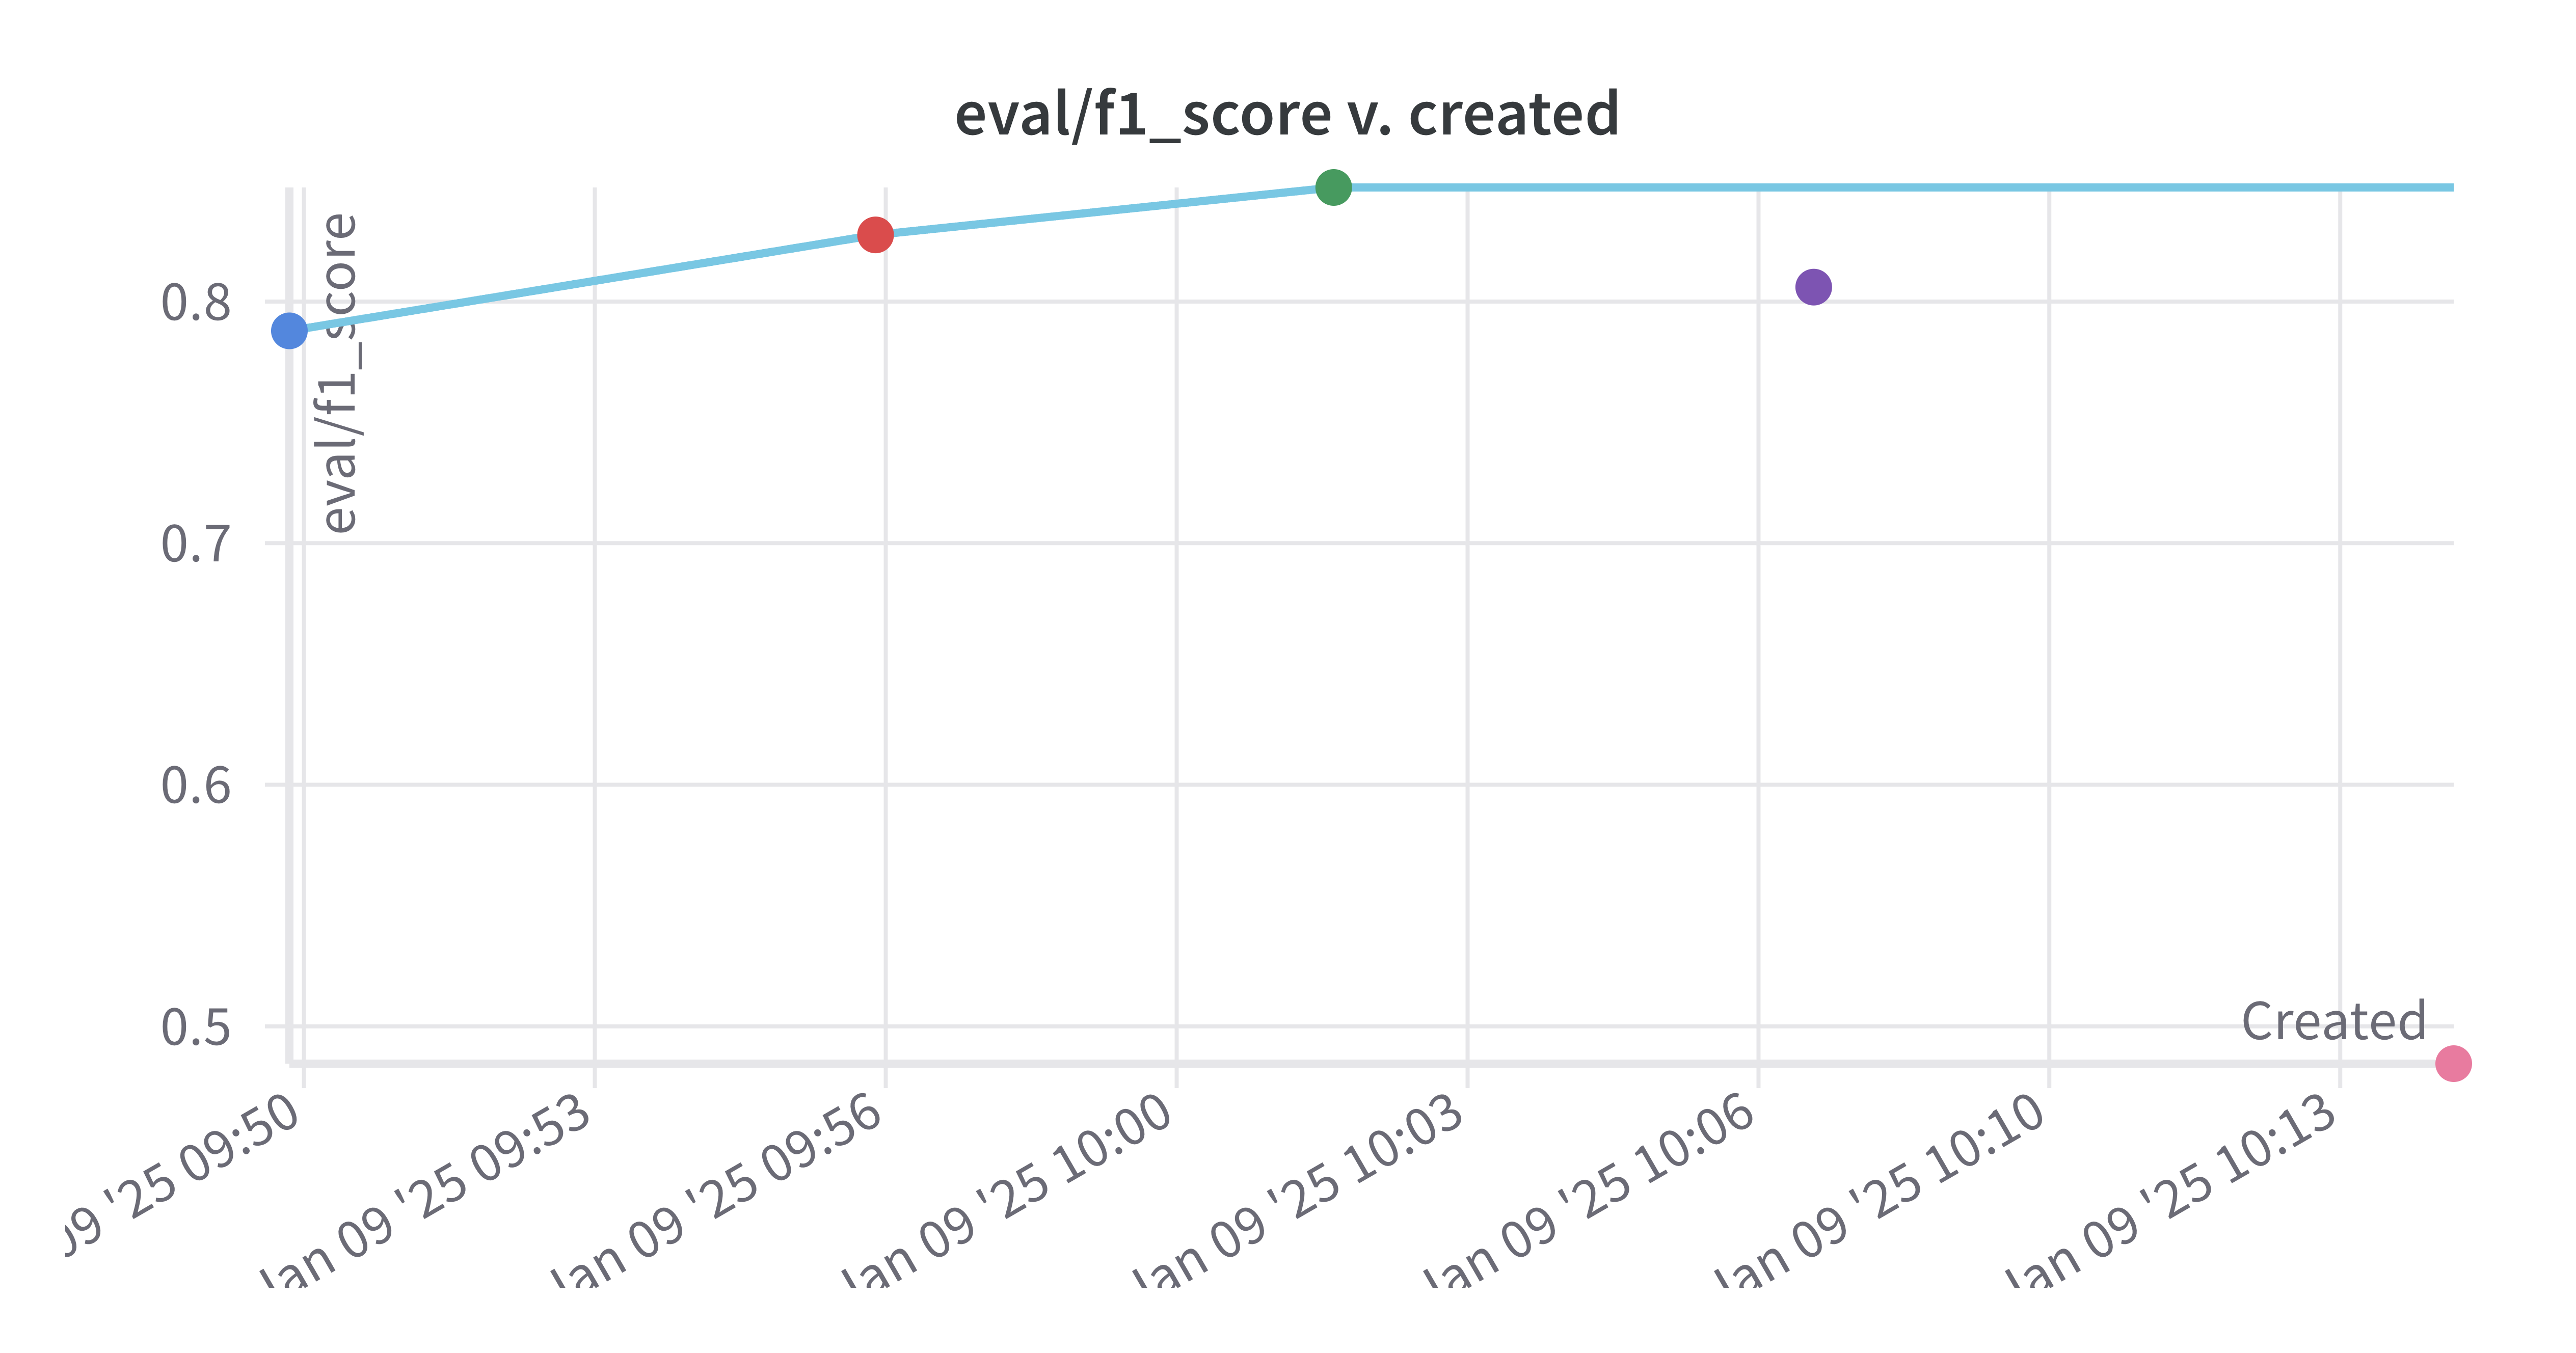

Once the sweep is stopped we can take a closer look at the W&B Dashboard.

1.	Open the W&B Sweep Dashboard (linked in the output).
2.	Locate the run with the highest F1 score in the summary.

The best-performing hyperparameters can then be used to retrain the model for final evaluation.

### Evaluation -- Retrain Best Model

After training and experimenting with various hyperparameters using Weights & Biases, we now want to select the best-performing configuration and retrain the model using those optimal settings. Next, we will evaluate our fine-tuned model on a held-out TEST dataset to obtain a realistic measure of its performance.


In [ ]:
import wandb
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = 'deepset/gbert-base'

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, predictions, average='binary'),
        "recall": recall_score(labels, predictions, average='binary'),
        "f1_score": f1_score(labels, predictions, average='binary')
    }

###################################
# 1) Load test data and label-encode
###################################
test_df = pd.read_csv("/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TEST.csv")
train_df = pd.read_csv("/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-TRAIN.csv")
val_df = pd.read_csv("/content/drive/MyDrive/2025-01-08-Call-To-Action-Ground-Truth-VAL.csv")

# Encode labels using the same LabelEncoder (important to use the fitted label_encoder!)

label_encoder = LabelEncoder()
label_encoder.fit(train_df["labels"])

test_labels = label_encoder.transform(test_df["labels"])
val_labels = label_encoder.transform(val_df["labels"])
train_labels = label_encoder.transform(train_df["labels"])

# Compute class weights (helpful for imbalanced classes)
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

###################################
# 2) Tokenize test data & create a Dataset object
###################################
tokenizer = AutoTokenizer.from_pretrained(MODEL)

test_encodings = tokenizer(
    test_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

val_encodings = tokenizer(
    val_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})


train_encodings = tokenizer(
    train_df["text"].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})


###################################
# 3) Use best hyperparameters from W&B
#    (Replace these placeholder values with your actual best hyperparameters)
###################################
best_learning_rate = 0.00002  # Example from a best run
best_weight_decay = 0.03      # Example from a best run
best_num_train_epochs = 6     # Example from a best run
best_batch_size = 8
best_warmup_steps = 0

# Define training arguments with best params
final_training_args = TrainingArguments(
    output_dir="./results_best",           # New or existing dir for best run
    num_train_epochs=best_num_train_epochs,
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    learning_rate=best_learning_rate,
    warmup_steps=best_warmup_steps,
    weight_decay=best_weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1_score",
    greater_is_better=True,
    load_best_model_at_end=True,
    logging_strategy="steps",
    logging_steps=10
)

In [ ]:
###################################
# 4) Initialize a fresh model with best hyperparams (or load from best checkpoint)
###################################
# Option A: Re-initialize a fresh model (if you want to fully retrain from scratch):
model_best = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=2,
    problem_type="single_label_classification"
)

# Option B: If you have a best checkpoint folder from your previous training:
# model_best = AutoModelForSequenceClassification.from_pretrained("/content/results_best/checkpoint-786")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer_best = CustomTrainer(
    model=model_best,
    args=final_training_args,
    train_dataset=train_dataset,  # Use your original training data
    eval_dataset=val_dataset,     # Use your original validation data
    compute_metrics=compute_metrics
)

###################################
# 5) Re-train on TRAIN + VAL (optional) or just TRAIN

trainer_best.train()

In [ ]:
###################################
# 6) Evaluate on the TEST dataset
###################################
test_results = trainer_best.evaluate(test_dataset)
print("Test results:", test_results)

Test results: {'eval_loss': 0.4913775324821472, 'eval_precision': 0.7580645161290323, 'eval_recall': 0.8703703703703703, 'eval_f1_score': 0.8103448275862069, 'eval_runtime': 4.1435, 'eval_samples_per_second': 67.093, 'eval_steps_per_second': 8.447, 'epoch': 6.0}


**Notes**

* Re-training vs. direct loading: If your TrainingArguments used load_best_model_at_end=True, then at the end of training Hugging Face automatically loads the best checkpoint. You could skip re-initializing and just do trainer.predict(test_dataset).
* Checkpoints: You may have a best checkpoint from your previous run stored in ./results/checkpoint-XXXX/. If so, loading that directly (Option B) can save time rather than re-training.
* Hyperparameters: Make sure to fill in the actual hyperparameter values from your W&B best run.

With this workflow, your final model (using the best hyperparameters) is evaluated on the **TEST** set, giving you a true performance estimate.

### Qualitative Introspection
In this section, we explore how to perform a qualitative introspection of your fine-tuned model by analyzing its predictions for a single input text. This allows us to interpret the model’s behavior in detail and assess how well it aligns with our expectations.

By providing a single text input, you can observe:
1.	The predicted label assigned by the model.
2.	The probabilities associated with each class, offering insight into the model’s confidence in its prediction.

Here we draw a single sample from the **TEST** dataset and classify the sample using our `best_model`:

In [ ]:
###################################
# Classify a custom text input
###################################

# Define a sample text input (students can modify this)
sample_text = test_df.sample(1).iloc[0]['text']

# Tokenize the input text
sample_encoding = tokenizer(
    sample_text,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

# Make a prediction using the trained model
model_best.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model_best(**sample_encoding)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1).cpu().numpy().flatten()  # Convert logits to probabilities
    predicted_class = np.argmax(probabilities)

# Map the predicted class back to its label
predicted_label = label_encoder.inverse_transform([predicted_class])[0]

# Map the predicted class back to its label
probabilities_readable = {label_encoder.inverse_transform([i])[0]: f"{prob:.2%}" for i, prob in enumerate(probabilities)}

# Display the results
print(f"Input text: {sample_text}")
print(f"Predicted label: {predicted_label}")
print("Class probabilities:")
for label, prob in probabilities_readable.items():
    print(f"  {label}: {prob}")

Input text: Wer das Klima schützt, schützt die Freiheit. Deshalb: Grün wählen am Sonntag  Robert Habeck die_gruenen Bei unserem Wahlkampfhöhepunkt in Düsseldorf macht @robert habeck noch mal klar: We .
Predicted label: True
Class probabilities:
  False: 0.03%
  True: 99.97%


Next, we want to classify the whole **TEST** dataset and take a look at the missmatches between annotations and classification: Even if a model achieves a high F1 score, it’s essential to review where it makes mistakes. By comparing the model’s predictions to the true labels on the TEST set, we can uncover specific data instances that are misclassified. These instances often provide valuable clues on:
* Ambiguous Text: Is the language in the misclassified examples unclear or context-dependent?
* Model Weaknesses: Are there certain textual patterns or classes where the model systematically underperforms?
* Label Noise: Are some ground truth labels potentially incorrect or inconsistent?

Reviewing these “problem” rows is a key step in error analysis, guiding targeted improvements such as refining the label schema, collecting additional training samples, or adjusting hyperparameters.

In [ ]:
###################################
# 1) Define a function for predictions with best_model
###################################

def predict_with_model(model, tokenizer, texts, device):
    """
    Use the fine-tuned model to predict probabilities for the given texts.
    """
    model.to(device)
    model.eval()  # Ensure the model is in evaluation mode

    # Tokenize the input texts
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
    )
    encodings = {key: tensor.to(device) for key, tensor in encodings.items()}  # Move tensors to device

    # Get predictions
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        predicted_classes = torch.argmax(probabilities, dim=-1)  # Get predicted class indices

    return predicted_classes.cpu().numpy(), probabilities.cpu().numpy()


###################################
# 2) Predict on the entire TEST dataset
###################################

# Prepare test texts and labels
test_texts = test_df["text"].tolist()  # The text column in your test dataset
test_true_labels = test_df["labels"].tolist()  # The true labels column in your test dataset

# Predict with the best model
predicted_indices, probabilities = predict_with_model(model_best, tokenizer, test_texts, device)

# Convert numeric indices back to string labels
predicted_labels = label_encoder.inverse_transform(predicted_indices)
true_labels = label_encoder.inverse_transform(test_true_labels)

###################################
# 3) Add predictions to the test DataFrame
###################################
test_df["true_label"] = true_labels            # Original ground-truth labels
test_df["predicted_label"] = predicted_labels  # Model predictions

###################################
# 4) Identify rows where prediction != ground truth
###################################
mismatches_df = test_df[test_df["true_label"] != test_df["predicted_label"]]

# Inspect mismatched examples
print(f"Number of mismatches: {len(mismatches_df)} (out of {len(test_df)})")
mismatches_df.head(10)  # Show first 10 rows of mismatches

Number of mismatches: 20 (out of 278)


Unnamed: 0                                               text  labels  \
4            77  🔷🔷 www.entlasten-statt-belasten.de 🔷🔷\n\nDie B...    True   
10          839  freie WÄHLER DER EINZUG IST ZUM GREIFEN NAH Am...    True   
12          349  20.15 Uhr das Triell. Und ja, guckt alle mit, ...    True   
21          855  Suche 0web De/gMax Markus Söder über Pendlerpr...   False   
41         1162  Csu Cdu Col C 2du CDU Cdu G Cl cu o Cou 0 ARMI...   False   
54          257  Heute Abend gilt's, heute Abend ist Olaf im Tr...    True   
57         1225  B U N D E S T A G $ W A H L 26 . $ EPTEMBER 20...   False   
107         561        CL CSU Sl C CDUCSU U Link zur Rede YOUTU BE    True   
145        1144  LIEBER ARMIN LASCHET; WILLKOMMEN IN DER CDU-HO...   False   
161         176  Wie will ich es schaffen, dass wir bei der Dig...    True   

     true_label  predicted_label  
4          True            False  
10         True            False  
12         True            False  
21        False             True  
41        False             True  
54         True            False  
57        False             True  
107        True            False  
145       False             True  
161        True            False

By reviewing `mismatches_df`, you can identify specific linguistic or contextual traits that challenge your model’s performance. However, identifying these misclassified cases is just the first step. To better understand why the model made these incorrect predictions—or even to gain deeper insight into correct ones—we need tools that can explain the inner workings of the model.

### LIME: Explaining Model Predictions

Local Interpretable Model-Agnostic Explanations (LIME) provides a powerful framework to uncover the reasoning behind a model’s predictions. While evaluation metrics like F1 score measure how well your model performs, LIME focuses on understanding why it makes certain decisions. By perturbing the input text and observing the changes in the model’s output, LIME approximates the local behavior of the model with a simpler, more interpretable model (often a linear one).

This approach allows us to:
* Identify the words or phrases most influential in the model’s predictions.
* Detect whether the model relies on spurious patterns (e.g., punctuation, stopwords) rather than meaningful features.
* Uncover potential biases or artifacts in the dataset that may affect the model’s behavior.


In [ ]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import torch
from lime.lime_text import LimeTextExplainer
from sklearn.base import BaseEstimator, ClassifierMixin

###################################
# 1) Create a custom wrapper for the Hugging Face model
###################################
class BERTTextClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, tokenizer, model, device):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device

    def fit(self, X, y=None):
        # No fitting needed since model is already fine-tuned
        return self

    def predict_proba(self, texts):
        """
        Returns probabilities for each class (shape: [len(texts), num_classes]).
        """
        encodings = self.tokenizer(
            texts, truncation=True, padding=True, max_length=512, return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**encodings)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
        return probs

    # Optional: define predict if you want to use e.g. c.predict()
    def predict(self, texts):
        probs = self.predict_proba(texts)
        return np.argmax(probs, axis=1)

# Instantiate the wrapper
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_best = AutoModelForSequenceClassification.from_pretrained("/content/results_best/checkpoint-786").to(device)
bert_classifier = BERTTextClassifier(tokenizer, model_best, device)

Now we are ready to test a first sample, let's draw sample for the `test_df` that contains a call to action:

In [ ]:
import torch

###################################
# 2) Create a LIME text explainer
###################################
class_names = list(label_encoder.classes_)
explainer = LimeTextExplainer(class_names=class_names)

###################################
# 3) Choose a sample text from your TEST set for explanation
###################################
sample_row = test_df[test_df['labels'] == True].sample(1)
sample_text = sample_row.loc[sample_row.index[0], "text"]  # Use label-based indexing
true_label = sample_row.loc[sample_row.index[0], "labels"]
print("True label:", true_label)

###################################
# 4) Generate a LIME explanation
###################################
exp = explainer.explain_instance(
    sample_text,                # Raw text
    bert_classifier.predict_proba,  # Our custom predict_proba
    num_features=6              # e.g., top 6 contributing tokens
)

print("Explainer as list:", exp.as_list())

# Show inline visualization (in a Jupyter notebook)
exp.show_in_notebook(text=True)

# Clear GPU memory
torch.cuda.empty_cache()

True label: True
Explainer as list: [('wählen', 0.8246954849671847), ('Morgen', 0.1752258730555039), ('muss', -0.09355316570586436), ('will', 0.09114492039972474), ('Es', -0.08862458525666292), ('es', -0.08626463496545621)]


Next, let's choose a random text without a call. Compare the two results!

In [ ]:
import torch

###################################
# 2) Create a LIME text explainer
###################################
class_names = list(label_encoder.classes_)
explainer = LimeTextExplainer(class_names=class_names)

###################################
# 3) Choose a sample text from your TEST set for explanation
###################################
sample_row = test_df[test_df['labels'] == False].sample(1)
sample_text = sample_row.loc[sample_row.index[0], "text"]  # Use label-based indexing
true_label = sample_row.loc[sample_row.index[0], "labels"]
print("True label:", true_label)

###################################
# 4) Generate a LIME explanation
###################################
exp = explainer.explain_instance(
    sample_text,                # Raw text
    bert_classifier.predict_proba,  # Our custom predict_proba
    num_features=6              # e.g., top 6 contributing tokens
)

print("Explainer as list:", exp.as_list())

# Show inline visualization (in a Jupyter notebook)
exp.show_in_notebook(text=True)

# Clear GPU memory
torch.cuda.empty_cache()

True label: False
Explainer as list: [('Wahlen', 6.333057160661201e-05), ('Faschisten', 3.63542810951013e-05), ('welches', 2.991850098997383e-05), ('nicht', 2.454653012673381e-05), ('Tagen', 2.4254615826150835e-05), ('In', 2.3577847476883908e-05)]


In these examples the model manage very well to distinguish between the subtle differences of *wählen* and *Wahlen*, even though *Wahlen* would have contributed to a `True` classification -- but did not outweigh the neutral language.

Let's turn to another interesting example, a sample from our `mismatches_df`:

In [ ]:
import torch

###################################
# 2) Create a LIME text explainer
###################################
class_names = list(label_encoder.classes_)
explainer = LimeTextExplainer(class_names=class_names)

###################################
# 3) Choose a sample text from your TEST set for explanation
###################################
sample_row = mismatches_df.sample(1)
sample_text = sample_row.loc[sample_row.index[0], "text"]  # Use label-based indexing
true_label = sample_row.loc[sample_row.index[0], "labels"]
print("True label:", true_label)

###################################
# 4) Generate a LIME explanation
###################################
exp = explainer.explain_instance(
    sample_text,                # Raw text
    bert_classifier.predict_proba,  # Our custom predict_proba
    num_features=6              # e.g., top 6 contributing tokens
)

print("Explainer as list:", exp.as_list())

# Show inline visualization (in a Jupyter notebook)
exp.show_in_notebook(text=True)

# Clear GPU memory
torch.cuda.empty_cache()

True label: True
Explainer as list: [('euch', 0.14309404712490376), ('wir', -0.12690338012696373), ('ja', -0.12476205066665681), ('Twittern', 0.11501270329441109), ('retweetet', 0.11195351790063254), ('beteiligt', 0.10609936972671957)]


The misclassification likely stems from the model overemphasizing neutral conversational words like “euch” and “wir” while underweighting actionable terms like “Twittern” and “retweetet”. This suggests a gap in the training data, where conversational calls to action and calls to interact are underrepresented. To improve, the model might benefit from additional examples of casual yet directive language to better balance its focus on actionable terms in such contexts. Our training data only contained a handful of audio transcriptions that contain calls to action!

## Conclusion

After all these steps we should have fine-tuned a robust binary text classification model based on BERT. You have successfully explored key concepts, including dataset preparation, train-test splits, and stratified sampling to reach a high classification quality. These skills form the bedrock of many NLP applications, where data often requires careful preprocessing and thoughtful evaluation.

**Next Steps**

* Multiclass Classification:
  Extend the workflow to support multiclass classification tasks by modifying the label encoding and adjusting the model’s output configuration. This expansion enables you to handle more complex classification problems, such as assigning multiple categories to textual data.

* Advanced Evaluation Techniques:

  Explore [k-fold cross-validation](https://medium.com/swlh/k-fold-as-cross-validation-with-a-bert-text-classification-example-4017f76a863a) to assess model generalization more rigorously, especially when working with small datasets.

* Data Augmentation:

  Address dataset limitations by generating synthetic examples (i.e. translating text back and forth using appropiate models, or tools like [TextAttack](https://github.com/QData/TextAttack)). Additionally, consider  GPT for paraphrasing or creating augmented training data, ensuring a balance between realism and diversity. (See i.e. [our paper on calls to action](https://arxiv.org/abs/2409.02690), or [Birkenmaier et al.'s paper on synthetic datasets](https://arxiv.org/abs/2410.12622)).

* Model Deployment:

  * Practice [saving](https://huggingface.co/docs/transformers/v4.47.1/en/main_classes/model#transformers.PreTrainedModel.save_pretrained) and [loading models](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.from_pretrained) for reproducibility and integration into downstream workflows.
  * [Share your fine-tuned model with the community using platforms like the Hugging Face Model Hub to encourage collaboration and feedback](https://huggingface.co/docs/transformers/v4.15.0/model_sharing).

* Expanding Modalities:

  * [Apply similar workflows to image classification tasks using Vision Transformers (ViT)](https://huggingface.co/docs/transformers/main/en/tasks/image_classification). While tokenization steps differ, you can still rely on the Hugging Face Trainer API for training and evaluation.


